In [1]:
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain_community.llms import LlamaCpp
from langchain.callbacks.manager import CallbackManager
import pandas as pd
from langchain import PromptTemplate
import re
import matplotlib.pyplot as plt
from prompt_templates import *


In [11]:
MODEL_PATH = {"Mixtral-8x-7b": "../models/mixtral-8x7b-instruct-v0.1.Q4_K_M.gguf",
               #"Llama2-70b": "llama2_70b_chat_uncensored.Q5_K_M",
               #"Dolphin-2.5": "dolphin-2.5-mixtral-8x7b.Q5_K_M",
               #"Yi-34b": "yi-34b-200k.Q5_K_M",
               #"Phi-2": "phi-2.Q5_K_M"
              }

#Set output file name
OUTPUT_PICKEL = "../data/llm_output_dataframe.pkl"

MAX_SAMPLING_RATE = 1

FEW_SHOT_TEMPLATE = """
    The following are multiple choice questions (with answers) about network fundamentals, network access,
    security fundamentals, automation and programmability. Here is an example
    
    Question: Which two options are the best reasons to use an IPV4 private IP space? (Choose two.)
    
    Choices:
    A. to enable intra-enterprise communication
    B. to implement NAT
    C. to connect applications
    D. to conserve global address space
    E. to manage routing overhead
                                               
    Correct Answer: ['A','D']
    
    Please give the answer in the following format:
        Correct Answer: ['A','D']           
    
    Now, answer the following question:
    Question: {Exam_Question}        
                    
    Choices:
    {Exam_Choices}
    """

PROBABILIY_ENABLED = True



In [3]:
#Valid Answers:
"""
    "Correct Answer: ['A','D']", 
    "Correct Answer: ['A']",
    "Correct Answer: [A]",
    "Correct Answer: [a]",
    "Correct Answer: [a,b]",
    "Correct Answer: [A,b]",
    "Correct Answer: ['a']",
    "Correct Answer: ['a','b']",
"""
def is_valid_answer(answer):
    """Checks if the provided answer is in the expected format.

    Keyword arguments:
    answer -- the answer string to check
    """
    pattern = r"Correct Answer:\s+\[(?:'[A-Ea-e]',?\s*)+\]" 
    match = re.search(pattern, answer)
    return match is not None

def extract_correct_answers(answer):
    """Extracts the correct answers from the provided answer string.

    Keyword arguments:
    answer -- the answer string to extract the correct answers from
    """
    pattern = r"Correct Answer:\s+\[(?:'[A-Ea-e]',?\s*)+\]" 
    match = re.search(pattern, answer)
    if match:
        correct_answers = re.findall(r"'[A-E]'", match.group())
        return [answer.strip("'") for answer in correct_answers]
    else:
        return None

def compare_answers(answerLLM, answer_exam):
    """Compares the extracted correct answers with the answers in answer_exam.

    Keyword arguments:
    answerLLM -- the list of answers extracted from the LLM answer
    answer_exam -- list of answers from the exam
    """

    # Convert the answer_exam string to a list of answers
    answer_exam_list = answer_exam.split(" ")
    #Get number of correct answers in the exam
    num_of_correct_exam_answers = len(answer_exam_list)
    

    # Convert both lists to sets for efficient comparison
    answer_LLM_set = set(answerLLM)
    answer_exam_set = set(answer_exam_list)

    # Calculate the count of matching answers
    number_of_correct_llm_answers = len(answer_LLM_set.intersection(answer_exam_set))

    # Check if the number of answers given by the LLM is greater than the number of correct answers
    too_many_answ_given = False
    if len(answer_LLM_set) > num_of_correct_exam_answers:
        too_many_answ_given = True
        


    # Return a dictionary with the matching count and the number of correct answers
    return number_of_correct_llm_answers, too_many_answ_given

def analyse_answer(llm_answer, exam_Answers):
    """Analyse the answer given by the LLM and compare it with the exam answers.

    Keyword arguments:
    llm_answer -- the answer string given by the LLM
    exam_Answers -- the list of answers from the exam
    """

    answerLLM = extract_correct_answers(llm_answer)
    if answerLLM is not None:
         num_of_correct_llm_Answers, too_many_answ = compare_answers(answerLLM, exam_Answers)
         return num_of_correct_llm_Answers, answerLLM, too_many_answ
    else:
         return -1

#####
# Partial Credit allowed?
####


def evaluation(llm_output_dataframe):

    # Compute the number of total questions for each model
    number_of_questions = llm_output_dataframe.groupby('Model')['QuestionIndex'].count()
    
    #Number of fully correct answers given by the LLM
    correctly_answered = llm_output_dataframe.groupby('Model')['Answered_Correctly'].sum()

    #Number of incorrect answers given by the LLM
    incorrectly_answered = number_of_questions - correctly_answered

    #Amount of correct answers in the exam
    amount_correcct_exam_answers = llm_output_dataframe.groupby('Model')['NumberOfCorrectExamAnswers'].sum()

    #Amount of correct answers given by the LLM even if not fully correct
    amount_correcct_llm_answers = llm_output_dataframe.groupby('Model')['NumberOfCorrectLLMAnswers'].sum()
    
    #Calculation of Precision and Recall and f1 score
    precision = correctly_answered / number_of_questions
    precision_partial = amount_correcct_llm_answers / amount_correcct_exam_answers


    results_df = pd.DataFrame({
        'Number of Questions': number_of_questions,
        'Correctly Answered': correctly_answered,
        'Incorrectly Answered': incorrectly_answered,
        'Precision': precision,
        'Precision Partial': precision_partial,
    })

    results_df = results_df.reset_index()

    return results_df


def plot_evaluation(evaluation_df):
    """
    Plots evaluation metrics from a DataFrame containing columns:
        - 'Model'
        - 'Precision'
        - 'Precision Partial'
    """
    # --- Subplot 1: Precision and Recall ---
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    bar_width = 0.35

    axs[0].bar(evaluation_df['Model'], evaluation_df['Precision'], bar_width, 
               label='Precision', color='#1f77b4')

    # Add percentages
    for i, row in evaluation_df.iterrows():
        axs[0].text(row['Model'], row['Precision'] + 0.01, f"{row['Precision']:.1%}", 
                    ha='center', color='black')

    axs[0].set_xlabel('Model')
    axs[0].set_ylabel('Percentage of Questions')
    axs[0].set_title('Precision and Recall', fontsize=12)
    axs[0].set_xticklabels(evaluation_df['Model'], rotation=45, ha='right', fontsize=10)
    axs[0].legend()

    # --- Subplot 2: Partial Precision ---
    axs[1].bar(evaluation_df['Model'], evaluation_df['Precision Partial'], bar_width,
               label='Precision Partial', color='#2ca02c')

    # Add percentages
    for i, score in enumerate(evaluation_df['Precision Partial']):
        axs[1].text(i + bar_width / 2, score + 0.01, f"{score:.1%}", ha='center', color='black')

    axs[1].set_xlabel('Model')
    axs[1].set_ylabel('Precision Partial')
    axs[1].set_title('Precision Partial', fontsize=12)
    axs[1].set_xticks([i + bar_width / 2 for i in range(len(evaluation_df))])
    axs[1].set_xticklabels(evaluation_df['Model'], rotation=45, ha='right', fontsize=10)

    fig.tight_layout()
    plt.show()

def extract_answer_from_text_file(path_to_text_file):
   # Read the text file
    with open(path_to_text_file, 'r') as file:
        lines = file.readlines()

    # Initialize lists to store data
    questions = []
    answers = []
    correct_answers = []

    # Parse the lines
    question = ""
    options = ""
    correct_option = ""
    for line in lines:
        line = line.strip()
        if line.startswith("Question:"):
            if question:  # If it's not the first question
                questions.append(question)
                answers.append(options)
                correct_answers.append(correct_option)
                options = ""  # Reset options for the new question
            question = line.replace("Question:", "").strip()
        elif line.startswith("Answer:"):
            correct_option = line.split(":")[-1].strip()
        elif line.startswith(("A.", "B.", "C.", "D.", "E.")):
            options += line.strip() + " "  # Add options to the string

    # Append the last question
    questions.append(question)
    answers.append(options)
    correct_answers.append(correct_option)

    # Create a DataFrame
    data = {
        'Question': questions,
        'Answers': answers,
        'Correct Answer': correct_answers
    }

    df = pd.DataFrame(data)
    return df


def split_options_string(options_string):
    # Use regular expression to split the string
    options_list = re.split(r'(?=[A-Z]\.)', options_string)
    
    # Remove any leading or trailing whitespace from each option
    options_list = [option.strip() for option in options_list if option.strip()]
    
    return options_list

def format_options_string(options_list):
    # Join the options list with newline characters
    formatted_options_string = '\n'.join(options_list)
    
    return formatted_options_string

In [4]:
questions = extract_answer_from_text_file("../data/questionbank_cisco_CCNP.txt")
callback_manager = CallbackManager([StreamingStdOutCallbackHandler()])
prompt_template = PromptTemplate.from_template(FEW_SHOT_TEMPLATE)



llm_exam_result = pd.DataFrame(columns = ["Model", "QuestionIndex", "SamplingIndex", "NumberOfCorrectLLMAnswers", "NumberOfCorrectExamAnswers", "Ratio", "LLM_Answer", "Exam_Answers", "Answered_Correctly",  "Too_Many_answers"]) 
valid_question_answer = False  
for model, model_path in MODEL_PATH.items():
    #Load the model wiht LLamaCpp
    llm = LlamaCpp(
        model_path= model_path,
        n_gpu_layers=128,
        n_batch=512,
        #max_tokens = 100,
        #callback_manager=callback_manager,
        verbose=False,  # Verbose is required to pass to the callback manager
    )

    chain = prompt_template | llm

ggml_init_cublas: GGML_CUDA_FORCE_MMQ:   no
ggml_init_cublas: CUDA_USE_TENSOR_CORES: yes
ggml_init_cublas: found 1 CUDA devices:
  Device 0: NVIDIA A100-SXM4-40GB, compute capability 8.0, VMM: yes


['A']
1 False
['C']
1 False
['A']
1 False
['B']
0 False
['B', 'C']
0 False
[]
0 False
['C']
1 False
['A']
1 False
['A']
1 False
['A', 'B', 'C']
1 False
[]
0 False
[]
0 False
['A', 'E', 'C']
1 False
['A', 'E']
1 False
['D']
0 False
['C']
0 False
['B']
0 False
['B', 'C', 'E']
2 False
['A', 'B', 'E']
2 False
['A', 'B', 'D']
2 False
['B', 'C', 'E']
3 False
['B']
1 False
['A']
0 False
['B', 'C', 'E']
2 False


/tmp/ipykernel_1812749/1186865398.py:144: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(evaluation_df['Model'], rotation=45, ha='right', fontsize=10)


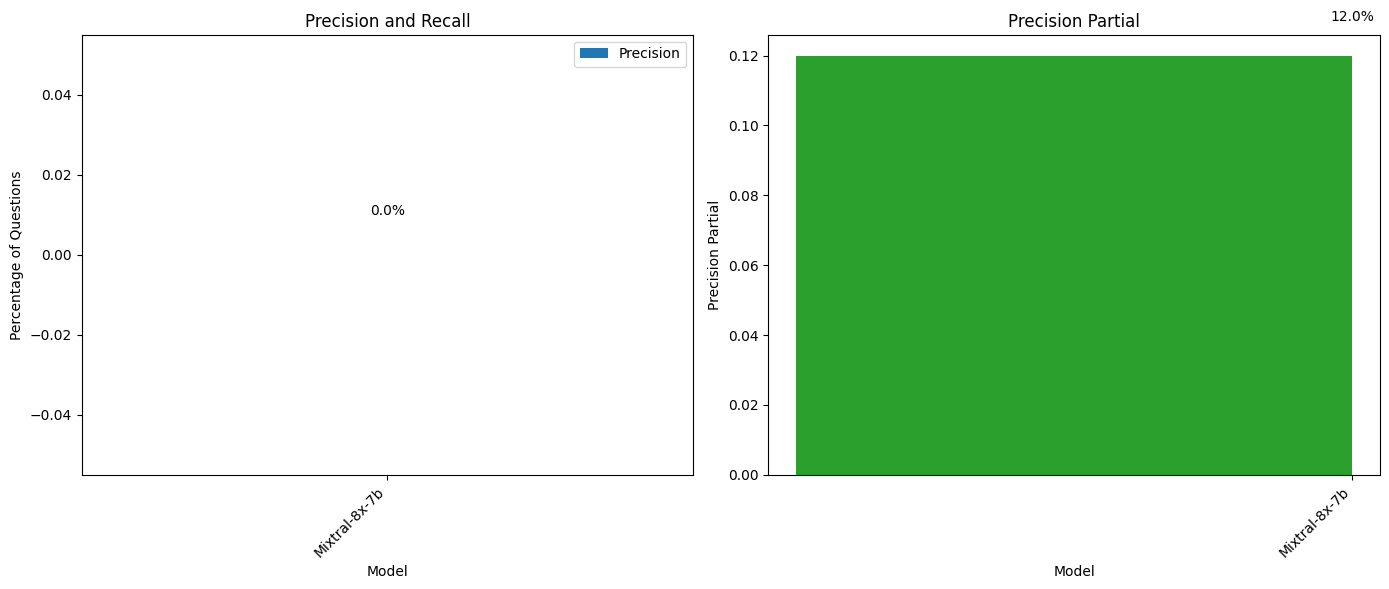

,Model,Number of Questions,Correctly Answered,Incorrectly Answered,Precision,Precision Partial
0,Mixtral-8x-7b,79,0,79,0.0,0.12


/usr/local/lib/python3.10/dist-packages/IPython/lib/pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/usr/local/lib/python3.10/dist-packages/IPython/core/formatters.py:344: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Mixtral-8x-7b,0,-1,0,1,-1,\n Correct Answer: ['A']\n \n Please ...,A,NaN,NaN
1,Mixtral-8x-7b,1,-1,0,1,-1,\n Correct Answer: ['B'],C,NaN,NaN
2,Mixtral-8x-7b,2,-1,0,1,-1,\n Correct Answer: ['member of'] \n ...,A,NaN,NaN
3,Mixtral-8x-7b,3,-1,0,1,-1,\n Correct Answer: ['B'] \n ...,A,NaN,NaN
4,Mixtral-8x-7b,4,-1,0,3,-1,"\n Correct Answer: ['A','C']",D E,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
74,Mixtral-8x-7b,19,0,2,5,0.4,"[A, B, D]",A B C,False,False
75,Mixtral-8x-7b,20,0,3,5,0.6,"[B, C, E]",B C E,False,False
76,Mixtral-8x-7b,21,0,1,1,1.0,[B],B,False,False
77,Mixtral-8x-7b,22,0,0,1,0.0,[A],B,False,False


In [17]:

valid_question_answer = False  
for model, model_path in MODEL_PATH.items():

    for index_question, row in questions.iterrows():
        question = row[0].strip()  # Get the value of the first column (question) and remove leading/trailing whitespace
        answer_exam = row[2].strip()    # Get the value of the third column (answer) and remove leading/trailing whitespace
        answer_exam_with_whitespace = ' '.join(list(answer_exam))
        
        num_of_correct_answer = len(answer_exam_with_whitespace)

        #Create the choices string like in the prompt template
        choices = ""  # Reset the choices variable for each question
        choices = split_options_string(row[1])
        choices = format_options_string(choices)
        
        char_probabilities = {}

        
        for index_sampling in range(MAX_SAMPLING_RATE):

            # Invoke the chain with the question and choices
            llm_answer = chain.invoke({"Exam_Question" : question, "Exam_Choices" : choices})

        
            # Check if the answer is in the expected format
            if is_valid_answer(llm_answer):

                #If probability is enabled, check what the correct answer is after all the sampling
                if not PROBABILIY_ENABLED:
                    # Extract the correct answers from the LLM answer and analyse the answer
                    num_of_correct_llm_answer, answerLLm, too_many_answers = analyse_answer(llm_answer, answer_exam_with_whitespace)

                    #Save the current sampling index -- How of the question has been asked until the answer was in the correct format
                    sample_Index = index_sampling
                    valid_question_answer = True

                    # Check if the number of correct answers given by the LLM is equal to the number of correct answers
                    if num_of_correct_llm_answer == num_of_correct_answer and too_many_answers == False:
                        answered_correctly = True
                    else :
                        answered_correctly = False
                    break
                else:
                    answer_letters = extract_correct_answers(llm_answer)
                    sample_Index = index_sampling
                    valid_question_answer = True
                    for letter in answer_letters:
                        if letter in char_probabilities:
                            char_probabilities[letter] += 1
                        else:
                            char_probabilities[letter] = 1
        
        
        if PROBABILIY_ENABLED:
            # Normalize probabilities
            total = sum(char_probabilities.values())
            for letter in char_probabilities:
                char_probabilities[letter] /= total

            # Sort characters by probability
            sorted_chars = sorted(char_probabilities.items(), key=lambda item: item[1], reverse=True)
            # Select answers based on the number of correct answers for the question
            answerLLm = [char for char, prob in sorted_chars[:num_of_correct_answer]]
            print(answerLLm)
            num_of_correct_llm_answer, too_many_answers = compare_answers(answerLLm, answer_exam_with_whitespace)
            print(num_of_correct_llm_answer, too_many_answers)
                       

        #Depending on the result of the answer, add the result to the dataframe
        if not valid_question_answer:
            new_row = pd.DataFrame({"Model": [model], "QuestionIndex": [index_question], "SamplingIndex": [-1], "NumberOfCorrectLLMAnswers": [0], "NumberOfCorrectExamAnswers": [num_of_correct_answer], "Ratio": [-1], "LLM_Answer": [llm_answer], "Exam_Answers": [answer_exam_with_whitespace]})
            llm_exam_result = pd.concat([llm_exam_result, new_row], ignore_index=True)
        else:
            new_row = pd.DataFrame({"Model": [model], "QuestionIndex": [index_question], "SamplingIndex": [sample_Index], "NumberOfCorrectLLMAnswers": [num_of_correct_llm_answer], "NumberOfCorrectExamAnswers": [num_of_correct_answer], "Ratio": [num_of_correct_llm_answer/num_of_correct_answer], "LLM_Answer": [answerLLm], "Exam_Answers": [answer_exam_with_whitespace], "Answered_Correctly" : [answered_correctly], "Too_Many_answers": [too_many_answers]})
            llm_exam_result = pd.concat([llm_exam_result, new_row], ignore_index=True)
            valid_question_answer = False
    answered_correctly = False

    evaluation_df = evaluation(llm_exam_result)
    plot_evaluation(evaluation_df)
    display(evaluation_df)
    display(llm_exam_result)


In [1]:

prompt_template = PromptTemplate.from_template(PROMPT_TEMPLATE)
questions = extract_answer_from_text_file("../data/questionbank_cisco_CCNP.txt")
callback_manager = CallbackManager([StreamingStdOutCallbackHandler()])



llm_exam_result = pd.DataFrame(columns = ["Model", "QuestionIndex", "SamplingIndex", "NumberOfCorrectLLMAnswers", "NumberOfCorrectExamAnswers", "Ratio", "LLM_Answer", "Exam_Answers", "Answered_Correctly",  "Too_Many_answers"]) 
valid_question_answer = False  
for model, model_path in MODEL_PATH.items():
    #Load the model wiht LLamaCpp
    llm = LlamaCpp(
        model_path= model_path,
        n_gpu_layers=128,
        n_batch=512,
        #max_tokens = 100,
        #callback_manager=callback_manager,
        verbose=False,  # Verbose is required to pass to the callback manager
    )

    chain = prompt_template | llm


    for index_question, row in questions.iterrows():
        question = row[0].strip()  # Get the value of the first column (question) and remove leading/trailing whitespace
        options = row[1].split('\n')  # Split the options by newline character
        options = [opt.strip() for opt in options]  # Strip leading/trailing whitespace from each option
        answer_exam = row[2].strip()    # Get the value of the third column (answer) and remove leading/trailing whitespace
        answer_exam_with_whitespace = ' '.join(list(answer_exam))
        options = list(filter(None, options))

        choices = ""  # Reset the choices variable for each question

        # Create the choices string
        for i, opt in enumerate(options):
            choices += f"{opt}" 

        for index_sampling in range(MAX_SAMPLING_RATE):
            # Invoke the chain with the question and choices
            print({"Exam_Question" : question, "Exam_Choices" : choices})


            llm_answer = chain.invoke({"Exam_Question" : question, "Exam_Choices" : choices})

            # Check if the answer is in the expected format
            if is_valid_answer(llm_answer):

                # Extract the correct answers from the LLM answer and analyse the answer
                num_of_correct_llm_answer, num_of_correct_answer, answerLLm, too_many_answers = analyse_answer(llm_answer, answer_exam_with_whitespace)
                sample_Index = index_sampling
                valid_question_answer = True

                # Check if the number of correct answers given by the LLM is equal to the number of correct answers
                if num_of_correct_llm_answer == num_of_correct_answer and too_many_answers == False:
                    answered_correctly = True
                else :
                    answered_correctly = False
                break
        if not valid_question_answer:
            llm_exam_result = llm_exam_result.append({"Model": model, "QuestionIndex": index_question, "SamplingIndex": -1, "NumberOfCorrectLLMAnswers": -1, "NumberOfCorrectExamAnswers": -1, "Ratio": -1, "LLM_Answer": llm_answer, "Exam_Answers": answer_exam_with_whitespace}, ignore_index=True)
        else:
            llm_exam_result = llm_exam_result.append({"Model": model, "QuestionIndex": index_question, "SamplingIndex": sample_Index, "NumberOfCorrectLLMAnswers": num_of_correct_llm_answer, "NumberOfCorrectExamAnswers": num_of_correct_answer, "Ratio": num_of_correct_llm_answer/num_of_correct_answer, "LLM_Answer": answerLLm, "Exam_Answers": answer_exam_with_whitespace, "Answered_Correctly" : answered_correctly, "Too_Many_answers": too_many_answers}, ignore_index=True)
            valid_question_answer = False
            answered_correctly = False

    display(llm_exam_result)
    evaluation_df = evaluation(llm_exam_result)
    #plot_evaluation(evaluation_df)
    display(evaluation_df)


ggml_init_cublas: GGML_CUDA_FORCE_MMQ:   no
ggml_init_cublas: CUDA_USE_TENSOR_CORES: yes
ggml_init_cublas: found 1 CUDA devices:
  Device 0: NVIDIA A100-SXM4-40GB, compute capability 8.0, VMM: yes
